# Data Project by VEM

## Introduction
In this project, we aim to create an easy and inituitive way of fetching data from Statistics Denmark, which can be presented in a nice and interactive plot. The user will be able to conduct moving average calculations on raw data and immediately see the results hereof. Hence, this project is suitable for volatile data, e.g. affected by seasonally factors.

## Import
We begin by importing all the necessary packages.
In order to properly install the PyDST package below, the first line of code is necessary.

In [1]:
!pip install git+https://github.com/elben10/pydst

import pydst                          # API from Statistics Denmark (DST)
Dst = pydst.Dst(lang='en')            # Specifies language as English
import pandas as pd                   # Data structure and analysis package
import numpy as np                    # Computing
import matplotlib.pyplot as plt       # Plots
import ipywidgets as widgets          # Interactive plots

  Cloning https://github.com/elben10/pydst to c:\users\emilha~1\appdata\local\temp\pip-req-build-mlbgfg1k
  Running setup.py bdist_wheel for pydst: started
  Running setup.py bdist_wheel for pydst: finished with status 'done'
  Stored in directory: C:\Users\EMILHA~1\AppData\Local\Temp\pip-ephem-wheel-cache-tcee67tm\wheels\d9\c4\ff\6f3f28e04ed27a83701d35fadebf3a7d9b11ba5b47b8d7e77f
Successfully built pydst


## Fetching and adjusting data
In this example, we fetch the table named NKN1 from the national accounts of Denmark.

In [2]:
Dst.get_data(table_id = 'NKN1')       # Retrieves NKN1

,TRANSAKT,PRISENHED,SÆSON,TID,INDHOLD
0,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",Non-seasonally adjusted,1990Q1,210.2


Now, we explore the contents of table NKN1.

In [3]:
Dst.get_variables(table_id = 'NKN1')  # Retrieves variables of NKN1

,elimination,id,text,time,values
0,False,TRANSAKT,transaction,False,"[{'id': 'B1GQK', 'text': 'B.1*g Gross domestic..."
1,False,PRISENHED,price unit,False,"[{'id': 'V_M', 'text': 'Current prices, (bill...."
2,False,SÆSON,seasonal adjustment,False,"[{'id': 'N', 'text': 'Non-seasonally adjusted'..."
3,False,Tid,time,True,"[{'id': '1990K1', 'text': '1990Q1'}, {'id': '1..."


Here, we wish to extracting the seasonally adjusted GDP in chained 2010-prices (bill. DKK) for the period 1990Q1 - 2018Q3.

In [4]:
df = Dst.get_data(table_id = 'NKN1',
     variables = {'TRANSAKT':['B1GQK'],
     'PRISENHED':['LKV_M'],
     'SÆSON':['Y'],'TID':['*']})        # Extracts the desired variables
pd.concat([df.head(3), df.tail(3)])     # Shows first three and last three rows  

,TRANSAKT,PRISENHED,SÆSON,TID,INDHOLD
0,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1990Q1,..
1,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1990Q2,..
2,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,1990Q3,..
113,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,2018Q1,508.1
114,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,2018Q2,511.2
115,B.1*g Gross domestic product,"2010-prices, chained values, (bill. DKK.)",Seasonally adjusted,2018Q3,513.5


We now remove redundant variables, so only time and GDP remain.

In [5]:
df1 = df.drop('TRANSAKT',1).drop('PRISENHED',1).drop('SÆSON',1) # Removes TRANSAKT, PRISENHED and SÆSON
pd.concat([df1.head(5), df1.tail(5)])                           # Shows first five and last five rows

,TID,INDHOLD
0,1990Q1,..
1,1990Q2,..
2,1990Q3,..
3,1990Q4,..
4,1991Q1,326.6
111,2017Q3,500.5
112,2017Q4,504.6
113,2018Q1,508.1
114,2018Q2,511.2
115,2018Q3,513.5


We then extract time and GDP as arrays. We also remove empty cells in GDP and convert this variable to the type of float.

In [6]:
time = df1['TID']                       # Extracts time
gdp  = df1['INDHOLD']                   # Extratcs GDP

gdp.replace('..',np.nan, inplace=True)
gdp.dropna(inplace=True)                # Removes empty cells
gdp = gdp.iloc[:].astype(float)         # Converts to float

gdp = gdp.reset_index(drop=True)        # Resets index

pd.concat([gdp.head(3), gdp.tail(3)])   # Shows first three and last three rows

0      326.6
1      325.4
2      329.5
109    508.1
110    511.2
111    513.5
Name: INDHOLD, dtype: float64

Above, we removed four empty cells in the GDP variable. In this case, these were the first four cells. Consequently, we now remove the first four time units in the variable time, so our data set becomes a perfectly balanced time series.

In [7]:
t = time[4:]                        # Removes first four time units
t = t.reset_index(drop=True)        # Resets index
pd.concat([t.head(3), t.tail(3)])   # Shows first three and last three rows

0      1991Q1
1      1991Q2
2      1991Q3
109    2018Q1
110    2018Q2
111    2018Q3
Name: TID, dtype: object

We now have exactly 111 + 1 rows for each of the two variables, GDP and t.

## Data description
Before we plot the data, we first take a little look at it.

In [13]:
pd.DataFrame(gdp.describe())

,INDHOLD
count,112.000000
mean,428.067857
std,52.958883
min,325.200000
25%,387.575000
50%,441.150000
75%,466.600000
max,517.800000


So when GDP was at its lowest, it was 325.2 bill. DKK, while its highest value was 517.8 bill. DKK. Furthermore, the mean GDP was 428 bill. DKK in the considered time period of almost 29 years.

Next, we calculate the growth rates of the Danish GDP. Here, we mark positive rates with green and negative rates with red.

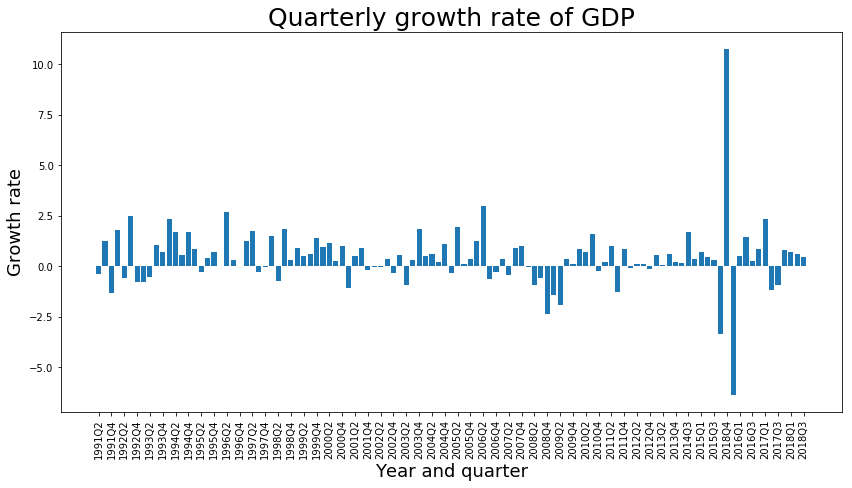

In [9]:
gr = (np.exp(np.diff(np.log(gdp))) - 1)*100           # Calculates GDP growth rate

plt.figure(figsize=(14,7))
plt.xlabel('Year and quarter', size=18)               # Labels the t variable
plt.ylabel('Growth rate', size=18)                    # Labels the gr variable
plt.bar(t[1:], gr, label='Quarterly growth rate')     # Plots gr
plt.title('Quarterly growth rate of GDP', size=25)    # Names the title of the plot
plt.xticks(t[0:], rotation='vertical')                # Makes the time units appear vertically on the x axis
plt.locator_params(axis='x', nbins=len(time[0:])/2)   # Shows every second time unit on the x axis

## Interactive plot
Below, we set-up the interactive plot, where X equals the amount of (moving) averaged quarters. We will plot this along with the raw data.

In [14]:
def MovAvg(X):

    plt.figure(figsize=(14,7))                                    # Adjusts the figure size
    plt.locator_params(which='x', tight=True, nbins=10)           # Initializes the slider
    plt.xlabel('Year and quarter', size=18)                       # Labels the t variable
    plt.ylabel('GDP', size=18)                                    # Labels the gdp variable
    plt.plot(t[0:],gdp.rolling(window=X, center=True).mean(),
                        label='GDP, moving average (X periods)')  # Plots and labels the mov. avg. series
    plt.plot(t[0:], gdp, label='GDP, observed')                   # Plots and labels the gdp series
    plt.title('GDP - Observed and Moving Average', size=25)       # Names the title of the plot
    plt.legend(loc='upper left')                                  # Places the legend
    plt.xticks(t[0:], rotation='vertical')                        # Makes the time units appear vertically on the x axis
    plt.locator_params(axis='x', nbins=len(time[0:])/2)           # Shows every second time unit on the x axis

widgets.interact(MovAvg, 
        X=widgets.IntSlider(min=0,max=12,step=1,value=6))         # Creates the slider

interactive(children=(IntSlider(value=6, description='X', max=12), Output()), _dom_classes=('widget-interact',…

<function __main__.MovAvg(X)>

Once one choose the desired amount of time units to average over, one can retrieve a table with all the averaged values below. The table can then be copied to another program, e.g. Excel, for further data processing.

In [11]:
def Table(X):                                                   # Defines function
        return pd.DataFrame(gdp.rolling(X, center=True).mean()) # Returns moving average of GDP

widgets.interact(Table,
        X=widgets.IntSlider(min=0,max=12,step=1,value=6))       # Creates and initialize a slider, which calls Table

interactive(children=(IntSlider(value=6, description='X', max=12), Output()), _dom_classes=('widget-interact',…

<function __main__.Table(X)>